In [95]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [96]:
br_path = 'data/cdmx_hex_1.geojson'
br = gpd.GeoDataFrame.from_file(br_path)

In [97]:
br.NSE_1.unique()

array([4, 3, 5, 6, 2, 1], dtype=int64)

In [98]:
br.shape

(2485, 6)

In [99]:
br.head()

,PobTot,Sup_ha,DenPob,NSE,NSE_1,geometry
0,2033,31.332682,64.884327,D+,4,(POLYGON ((-99.21223709630371 19.4013837385655...
1,4672,31.344373,149.053867,C,3,(POLYGON ((-99.13947973258153 19.5577093353181...
2,8195,31.332261,261.551506,D+,4,(POLYGON ((-99.21234843990824 19.3959489106918...
3,2883,31.333759,92.009389,C,3,(POLYGON ((-99.17221578985831 19.4169511126421...
4,7483,31.345368,238.727459,C,3,(POLYGON ((-99.13422725847636 19.5712047611096...


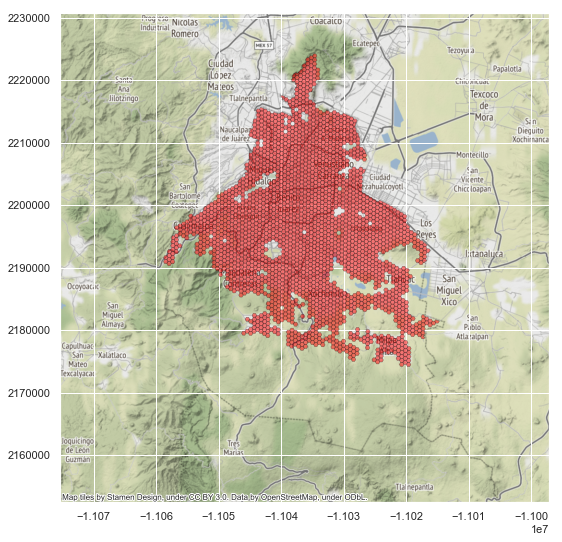

In [100]:
# Transforma a Web Mercator CRS y grafica 
ax = br.to_crs(epsg=3857).plot(figsize=(9, 9), alpha=0.5, color='red', edgecolor='k', lw= .5);
# Agrega mapa base
ctx.add_basemap(ax)

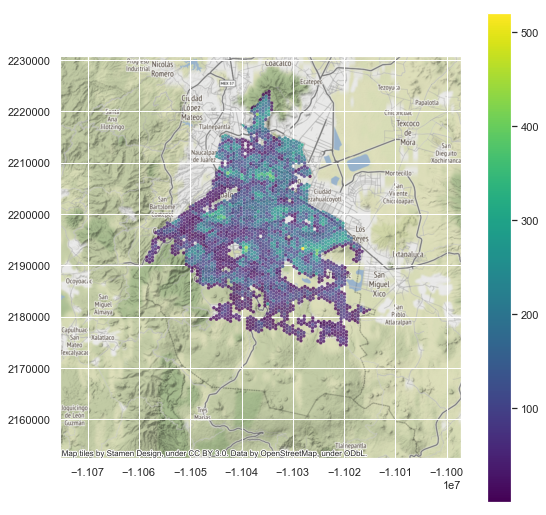

In [101]:
ax = br.to_crs(epsg=3857).plot(column = 'DenPob', cmap= 'viridis', edgecolor='w', lw= .1, legend = True, figsize=(9, 9), alpha=0.75);
# Agrega mapa base
ctx.add_basemap(ax)

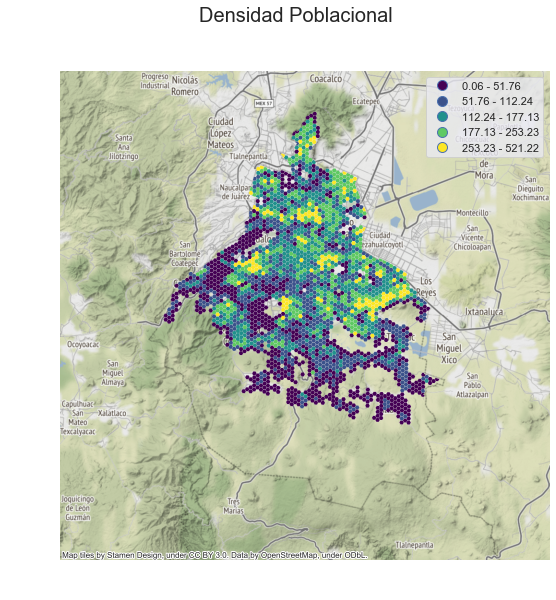

In [102]:
# Se ajusta la figura y los ejes
f, ax = plt.subplots(1, figsize=(9, 9))

# Grafica % en favor 
ax = br.to_crs(epsg=3857).plot(column='DenPob', scheme='fisher_jenks', legend=True, ax=ax, cmap='viridis', lw= .1)

# Remueve el marco de los ejes
ax.set_axis_off()

# Cambia el color de fondo
#f.set_facecolor('0.75')

# Titulo
f.suptitle('Densidad Poblacional', size=20)

# Agrega mapa base
ctx.add_basemap(ax)

# Despliegue de la gráfica
plt.show()

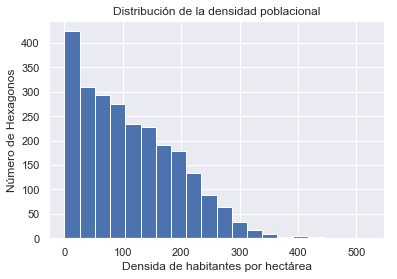

In [103]:
br['DenPob'].hist(bins=20)
plt.xlabel('Densida de habitantes por hectárea')
plt.ylabel('Número de Hexagonos')
plt.title('Distribución de la densidad poblacional')
plt.show()

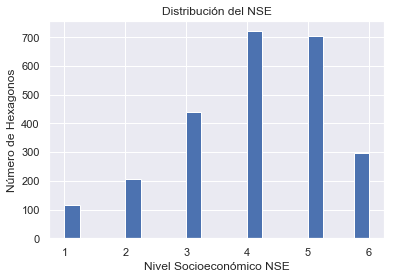

In [104]:
br['NSE_1'].hist(bins=20)
plt.xlabel('Nivel Socioeconómico NSE')
plt.ylabel('Número de Hexagonos')
plt.title('Distribución del NSE')
plt.show()

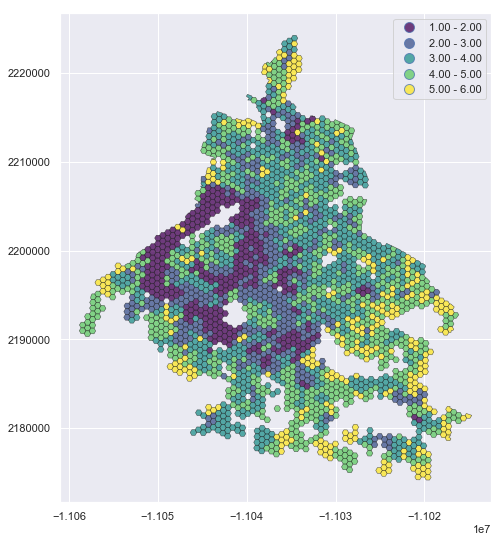

In [105]:
br.to_crs(epsg=3857).plot(column = 'NSE_1',scheme='equal_interval', cmap= 'viridis', edgecolor='k', lw= .5, legend = True, figsize=(9, 9), alpha=0.75);


## Matriz de pesos

In [106]:
w = ps.weights.Queen.from_dataframe(br)
w

C:\Users\aCortes\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\weights\weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
C:\Users\aCortes\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\weights\weights.py:187: UserWarning: Island id: 632
  warnings.warn("Island id: %s" % str(self.islands[0]))


In [107]:
# Estandarizando los renglones de la matriz
w.transform = 'R'
w

('WARNING: ', 632, ' is an island (no neighbors)')


## Retraso espacial

In [108]:
br['NSE_1'] = br['NSE_1']

In [109]:
br['z_NSE'] = (br['NSE_1']- br['NSE_1'].mean())/br['NSE_1'].std()

In [110]:
br['lag_NSE'] = ps.lag_spatial(w, br['z_NSE'])

 ## Autocorrelación Espacial

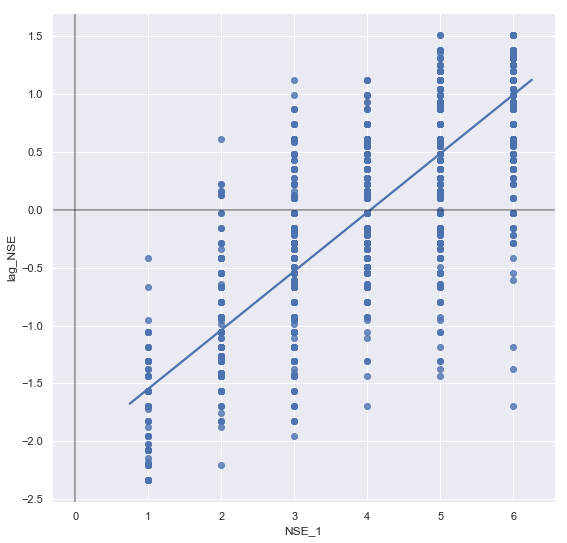

In [111]:
# Ajustamos la figura y los ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Graficamos 
sns.regplot(x='NSE_1', y='lag_NSE', data=br, ci=None)
# Agergamos líneas horizontal y vertical
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Despliegue
plt.show();

In [112]:
mi = ps.Moran(br['NSE_1'], w)

In [113]:
#Desplegamos el valor de la I de Moran
mi.I

0.6614953397576349

In [114]:
# Obtenemos la pseudo significancia del patrón observado
mi.p_sim

0.001

## Autocorrelación Espacial

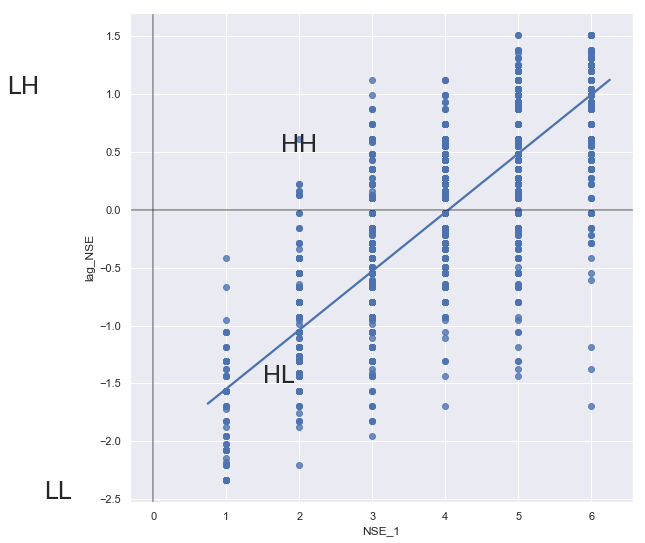

In [115]:
# Ajustamos la figura y los ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Graficamos los valores
sns.regplot(x='NSE_1', y='lag_NSE', data=br, ci=None)
# Agregamos líneas verticales, horizontales y etiquetas
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)
# Desplegamos la gráfica
plt.show();

In [117]:
lisa = ps.Moran_Local(br['NSE_1'], w)

C:\Users\aCortes\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\esda\moran.py:861: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


In [118]:
# Separa a las observaciones en significativas o no
br['significant'] = lisa.p_sim < 0.05
# Almacenamos el cuadrante al que pertenecen las observaciones
br['quadrant'] = lisa.q

In [119]:
br['significant'].head()

0    False
1     True
2    False
3     True
4    False
Name: significant, dtype: bool

In [120]:
lisa.p_sim[:5]

array([0.261, 0.019, 0.48 , 0.004, 0.139])

In [121]:
br['quadrant'].head()

0    3
1    2
2    3
3    3
4    2
Name: quadrant, dtype: int32

## Mapa de Clusters

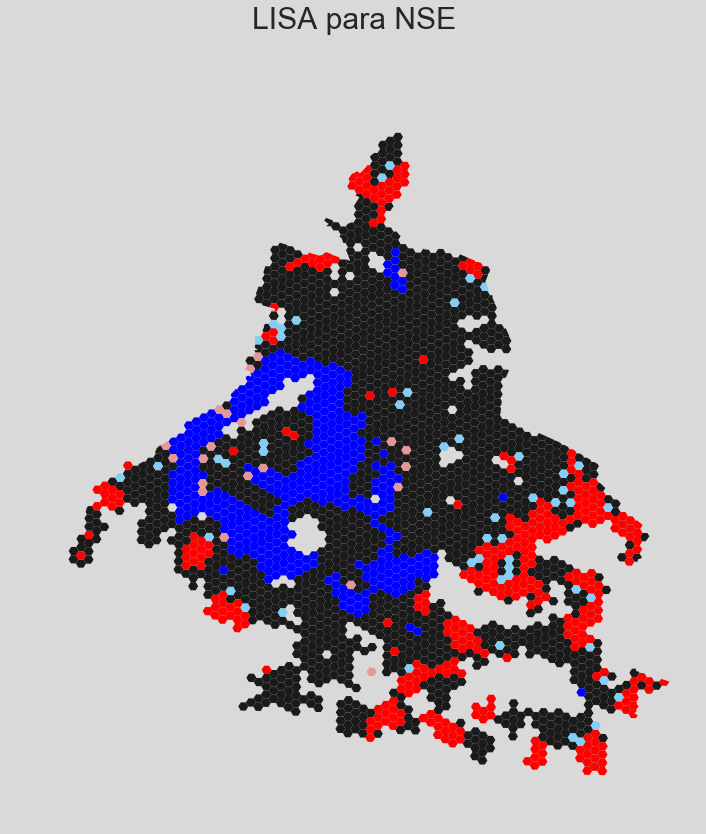

In [122]:
# Ajusta la figura y los ejes
f, ax = plt.subplots(1, figsize=(17, 13))
# Grafica observaciones no significativas
ns = br.loc[br['significant']==False, 'geometry']
ns.plot(ax=ax, color='k', edgecolor = 'none')
# Grafica clusters Alto-Alto
hh = br.loc[(br['quadrant']==1) & (br['significant']==True), 'geometry']
hh.plot(ax=ax, color='red', edgecolor = 'none')
# Grafica clusters Bajo-Bajo
ll = br.loc[(br['quadrant']==3) & (br['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue', edgecolor = 'none')
# Grafica anomalías espacials Bajo-ALto
lh = br.loc[(br['quadrant']==2) & (br['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4', edgecolor = 'none')
# Grafica anomalías espaciales Alto-Bajo
hl = br.loc[(br['quadrant']==4) & (br['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696', edgecolor = 'none')
# Estilo y despliegue
f.suptitle('LISA para NSE', size=30)
f.set_facecolor('0.85')
ax.set_axis_off()
plt.show();